## Load Packages and Data 

In [2]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random as random
import torch.nn as nn
from scipy.stats import norm
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from LSTM_helper import *

In [4]:
spy = pd.read_csv("spy_full.csv")
spy_week = pd.read_csv("spy_week.csv")
spy_month = pd.read_csv("spy_month.csv")

## Set Up GPU for model training 

* Ensure that the GPU is readily available
* Fix a seed for training and set the CUDA environment to be deterministic to ensure the results are reproducible. 

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU environments
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA version:", torch.version.cuda)
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Count:", torch.cuda.device_count())
    device = torch.device("cuda")  # Set device to GPU
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("CUDA is not available. Using CPU.")

CUDA version: 12.1
GPU Name: NVIDIA GeForce RTX 4070 SUPER
GPU Count: 1


## Examine data 

In [8]:
spy_month['date'] = pd.to_datetime(spy['date'])
initial_price = spy_month['close_price'].iloc[-1]
spy_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           383 non-null    datetime64[ns]
 1   close_price    383 non-null    float64       
 2   simple_return  383 non-null    float64       
 3   log_return     383 non-null    float64       
 4   days_elapsed   383 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 15.1 KB


## Setting up model training 
* Defines the necessary variables for train test split 
* Ensures that the training and test data are split sequentially
* Converts all training and test sets into tensors for GPU to process
* Create the model 

In [10]:
# Extract log returns and initialize parameters
log_returns = spy_month['log_return']
seq_length = 120  # Number of months in each sequence
initial_price = spy_month['close_price'].iloc[-1]  # Last known price

# Create sequences from log returns
X, y = create_sequences(log_returns.values, seq_length)

# Compute train-test split sizes
total_sequences = len(X)
train_size = int(total_sequences * 0.8)  # 80% for training
test_size = total_sequences - train_size  # 20% for testing

# Split the data sequentially for time series
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)  # Shape: (train_size, seq_length, input_size)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (train_size, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)  # Shape: (test_size, seq_length, input_size)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (test_size, 1)

# Ensure model is on the correct device
model = SPYLSTM(input_size=1, hidden_size=50, output_size=1, num_layers=2, dropout=0.2).to(device)

# Print dataset sizes for confirmation
print(f"Total sequences: {total_sequences}")
print(f"Training size: {train_size}, Testing size: {test_size}")

Total sequences: 263
Training size: 210, Testing size: 53


## Train the model 



In [12]:
# Training loop
num_epochs = 550
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create a DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size of 32

# Initialize list to store loss values for plotting
loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    # Append epoch loss to history
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/550, Loss: 0.0260
Epoch 2/550, Loss: 0.0250
Epoch 3/550, Loss: 0.0188
Epoch 4/550, Loss: 0.0194
Epoch 5/550, Loss: 0.0194
Epoch 6/550, Loss: 0.0178
Epoch 7/550, Loss: 0.0168
Epoch 8/550, Loss: 0.0188
Epoch 9/550, Loss: 0.0167
Epoch 10/550, Loss: 0.0171
Epoch 11/550, Loss: 0.0193
Epoch 12/550, Loss: 0.0184
Epoch 13/550, Loss: 0.0160
Epoch 14/550, Loss: 0.0169
Epoch 15/550, Loss: 0.0176
Epoch 16/550, Loss: 0.0171
Epoch 17/550, Loss: 0.0169
Epoch 18/550, Loss: 0.0176
Epoch 19/550, Loss: 0.0166
Epoch 20/550, Loss: 0.0162
Epoch 21/550, Loss: 0.0165
Epoch 22/550, Loss: 0.0166
Epoch 23/550, Loss: 0.0160
Epoch 24/550, Loss: 0.0165
Epoch 25/550, Loss: 0.0166
Epoch 26/550, Loss: 0.0161
Epoch 27/550, Loss: 0.0164
Epoch 28/550, Loss: 0.0173
Epoch 29/550, Loss: 0.0170
Epoch 30/550, Loss: 0.0163
Epoch 31/550, Loss: 0.0167
Epoch 32/550, Loss: 0.0169
Epoch 33/550, Loss: 0.0168
Epoch 34/550, Loss: 0.0170
Epoch 35/550, Loss: 0.0158
Epoch 36/550, Loss: 0.0187
Epoch 37/550, Loss: 0.0174
Epoch 38/5

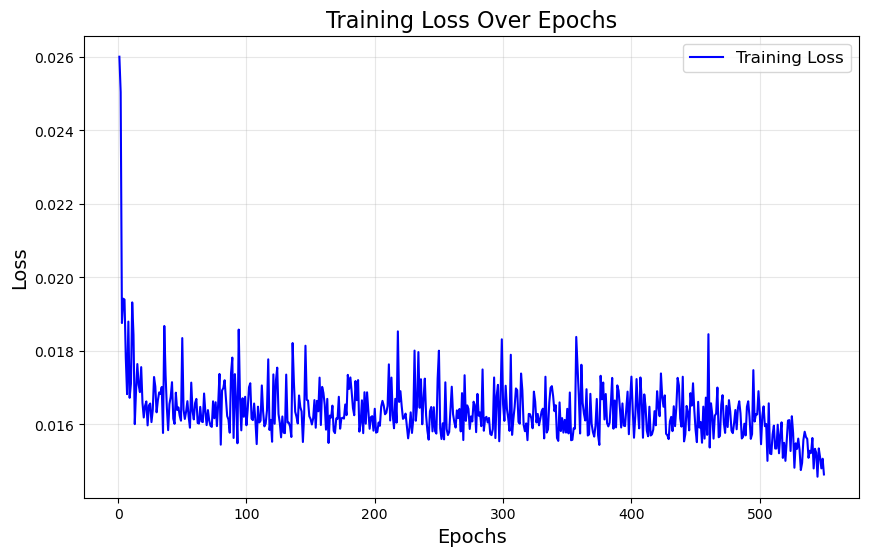

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label="Training Loss", color='blue')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Model Inference

In [15]:
# Testing the model
model.eval()  # Set the model to evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    outputs = model(X_test)  # Forward pass on the test set
    test_loss = criterion(outputs, y_test)  # Compute test loss

print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0022


## Make predictions in the next 20 years

In [17]:
# Convert log_returns to a NumPy array
log_returns = spy['log_return'].values 

# Forecast the next 20 years (~240 months)
initial_sequence = log_returns[-seq_length:]  # Use the last 250 monthly log returns as input
steps = 20 * 12  # Forecast Next 240 months 

mean_log_returns, lower_log_returns, upper_log_returns, forecasted_simulations = forecast_with_ci(
    model, initial_sequence, steps, num_simulations=100
)

initial_price = spy['close_price'].iloc[-1]  # Last known price
mean_prices = log_returns_to_prices(mean_log_returns, initial_price)
lower_prices = log_returns_to_prices(lower_log_returns, initial_price)
upper_prices = log_returns_to_prices(upper_log_returns, initial_price)

# Display the last 10 forecasted log returns
print("Mean Log Returns (last 10 months):", mean_log_returns[-10:].cpu().numpy())
print("Lower Bound Log Returns (last 10 months):", lower_log_returns[-10:].cpu().numpy())
print("Upper Bound Log Returns (last 10 months):", upper_log_returns[-10:].cpu().numpy())

# Display the last 10 forecasted prices
print("Mean Prices (last 10 months):", mean_prices[-10:].cpu().numpy())
print("Lower Bound Prices (last 10 months):", lower_prices[-10:].cpu().numpy())
print("Upper Bound Prices (last 10 months):", upper_prices[-10:].cpu().numpy())

Mean Log Returns (last 10 months): [0.00745195 0.00730651 0.00769039 0.00755196 0.00829065 0.00748594
 0.00743376 0.00768402 0.00783663 0.00792147]
Lower Bound Log Returns (last 10 months): [0.00410876 0.00327276 0.00378936 0.00381354 0.00443371 0.00387387
 0.00350402 0.00418838 0.00387698 0.00441279]
Upper Bound Log Returns (last 10 months): [0.01079514 0.01134026 0.01159143 0.01129038 0.01214759 0.01109801
 0.01136351 0.01117967 0.01179628 0.01143014]
Mean Prices (last 10 months): [3409.3918 3434.3933 3460.9072 3487.1423 3516.1733 3542.5942 3569.027
 3596.5571 3624.8525 3653.681 ]
Lower Bound Prices (last 10 months): [1403.4095 1408.0101 1413.3556 1418.756  1425.06   1430.5914 1435.6129
 1441.6385 1447.2385 1453.639 ]
Upper Bound Prices (last 10 months): [8282.649 8377.112 8474.779 8571.005 8675.757 8772.577 8872.832 8972.585
 9079.054 9183.424]


# Check for normality in the predictions

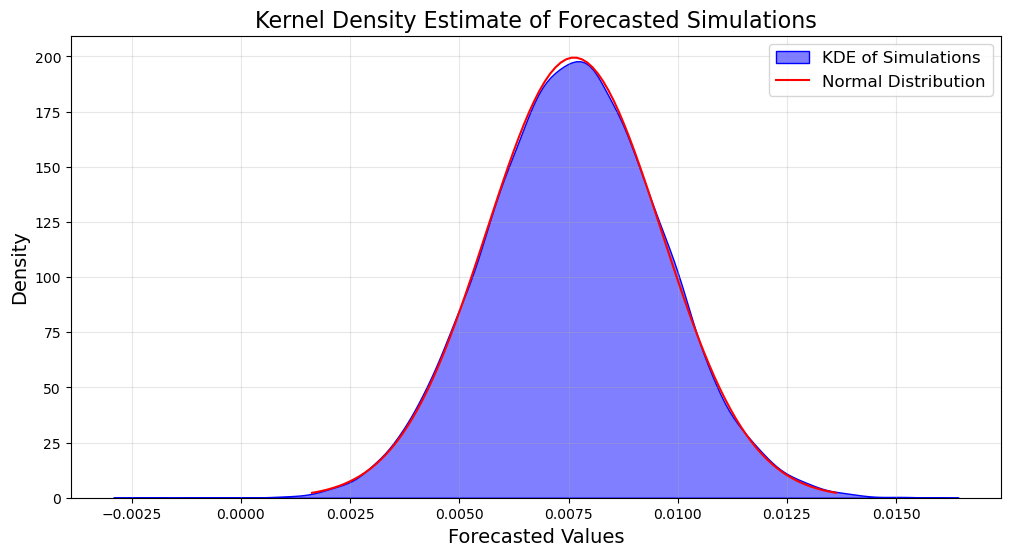

In [19]:
flattened_simulations = forecasted_simulations.flatten().cpu().numpy()

plt.figure(figsize=(12, 6))
sns.kdeplot(flattened_simulations, fill=True, color='blue', label='KDE of Simulations', alpha=0.5)

mean = np.mean(flattened_simulations)
std = np.std(flattened_simulations)
x = np.linspace(mean - 3*std, mean + 3*std, 100)
plt.plot(x, norm.pdf(x, mean, std), color='red', label='Normal Distribution')
plt.title("Kernel Density Estimate of Forecasted Simulations", fontsize=16)
plt.xlabel("Forecasted Values", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

## Visualise returns

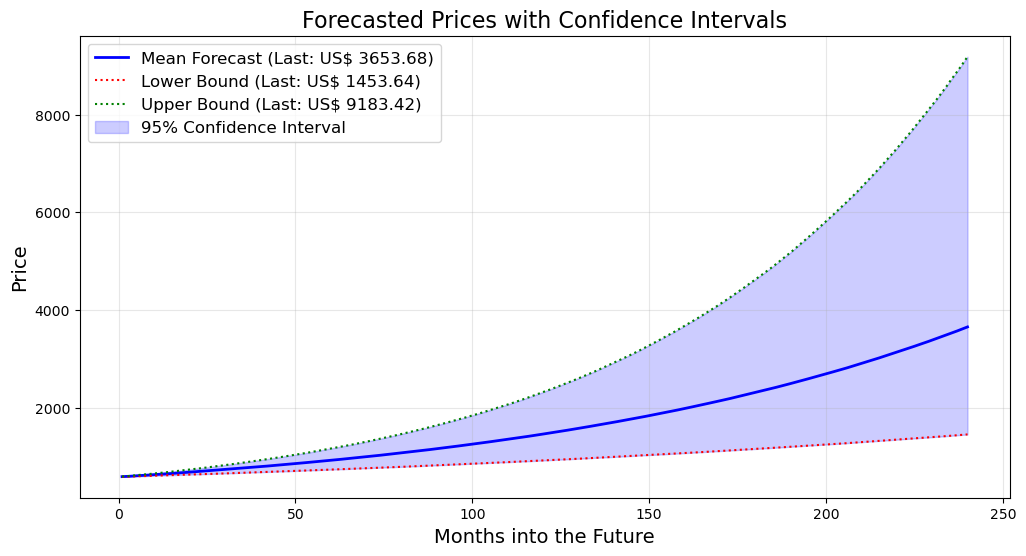

In [21]:
plot_forecast(mean_prices, lower_prices, upper_prices, steps=240)

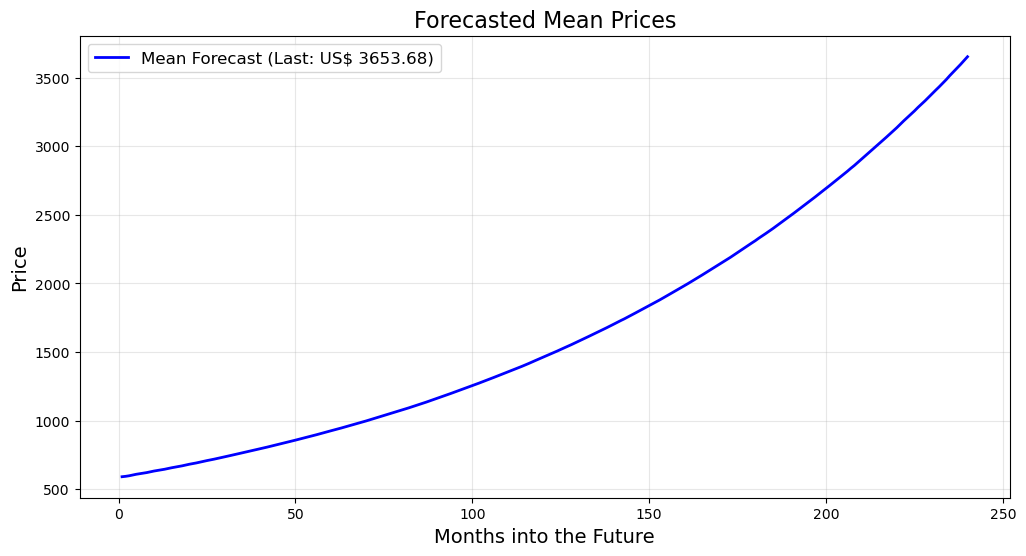

In [22]:
plot_mean_forecast(mean_prices, steps=240)

In [23]:
mean_prices = log_returns_to_prices(mean_log_returns, initial_price)

In [24]:
mean_prices = mean_prices.cpu().numpy().round(2)
mean_prices 

array([ 589.89,  592.77,  596.77,  602.23,  607.7 ,  611.88,  615.65,
        620.16,  625.83,  631.16,  635.5 ,  639.36,  644.25,  649.85,
        655.22,  659.66,  664.24,  669.36,  675.28,  680.86,  685.68,
        690.44,  696.16,  701.89,  707.54,  712.42,  717.86,  723.74,
        729.86,  735.45,  740.8 ,  746.38,  752.21,  758.36,  764.2 ,
        770.  ,  775.79,  782.08,  788.  ,  794.12,  799.95,  805.79,
        812.05,  818.89,  824.87,  830.79,  836.99,  843.63,  850.13,
        856.64,  863.19,  869.6 ,  876.55,  883.21,  889.8 ,  896.47,
        903.68,  910.81,  918.02,  924.7 ,  931.41,  938.41,  945.43,
        952.68,  959.72,  966.73,  974.38,  981.79,  989.28,  996.84,
       1004.68, 1012.55, 1020.15, 1027.45, 1035.62, 1043.61, 1051.35,
       1059.01, 1067.17, 1075.49, 1083.67, 1091.77, 1100.13, 1108.63,
       1117.34, 1125.67, 1134.2 , 1143.51, 1152.32, 1161.46, 1170.34,
       1179.33, 1188.62, 1197.79, 1207.16, 1216.05, 1225.49, 1235.28,
       1245.3 , 1254

In [25]:
dates_monthly = pd.date_range(start="2025-01-01", periods=len(mean_prices), freq="MS")

# Create a DataFrame with the adjusted dates
forecast_df = pd.DataFrame({
    "date": dates_monthly,
    "forecast": mean_prices 
})

In [26]:
forecast_df

,date,forecast
0,2025-01-01,589.890015
1,2025-02-01,592.770020
2,2025-03-01,596.770020
3,2025-04-01,602.229980
4,2025-05-01,607.700012
...,...,...
235,2044-08-01,3542.590088
236,2044-09-01,3569.030029
237,2044-10-01,3596.560059
238,2044-11-01,3624.850098


In [27]:
forecast_df.to_csv('lstm_forecast.csv')